# Analyse des données issues des ventes en ligne de l'entreprise 

In [274]:
# importation des librairies
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import locale
from sklearn.impute import SimpleImputer
import seaborn as sns

In [216]:
# lecture des fichiers csv
df_vente = pd.read_csv("ventes.csv")
df_client = pd.read_csv("clients.csv")
df_produit = pd.read_csv("produits.csv")

In [217]:
# exploration des données grâce à .info() et .head()


In [218]:
df_vente.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     337016 non-null  object
 1   date        337016 non-null  object
 2   session_id  337016 non-null  object
 3   client_id   337016 non-null  object
dtypes: object(4)
memory usage: 10.3+ MB


In [219]:
df_vente.head()


,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [220]:
df_client.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [221]:
df_client.head(5)


,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [222]:
df_produit.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [223]:
df_produit.head()


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


# Mission n° 1 : Nettoyage des données 

## Valeurs manquantes : 

In [224]:
df_vente.isnull().sum()


id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [225]:
df_client.isnull().sum()


client_id    0
sex          0
birth        0
dtype: int64

In [226]:
df_produit.isnull().sum()


id_prod    0
price      0
categ      0
dtype: int64

Il n'y a pas de valeurs manquantes dans ces 3 fichiers.

## Duplicates : 

In [227]:
df_client.duplicated("client_id").value_counts()

False    8623
dtype: int64

In [228]:
df_produit.duplicated("id_prod").value_counts()

False    3287
dtype: int64

In [229]:
# On remarque qu'il y a des duplicates dans ce dataframe
df_vente.duplicated(subset=None).value_counts()


False    336890
True        126
dtype: int64

In [230]:
# Visualisation des duplicates pour mieux les comprendres et savoir si on doit supprimer les lignes
df_vente.sort_values("date")
bool_series = df_vente["date"].duplicated()
df_vente[bool_series].head(5)


,id_prod,date,session_id,client_id
27161,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_0
34387,T_0,test_2021-03-01 02:30:02.237443,s_0,ct_0
48425,T_0,test_2021-03-01 02:30:02.237443,s_0,ct_1
54813,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1
56373,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_0


In [231]:
# Visualisation du produit T_0 dans la dataframe produit
df_produit.loc[df_produit["id_prod"] == "T_0"]

,id_prod,price,categ
731,T_0,-1.0,0


In [232]:
# Les duplicates de la dataframe df_vente, sont des tests effectués le 2021-03-01, ils ne sont pas intéréssant pour nos statistiques de vente, on peut donc les supprimer
df_vente.drop(df_vente.index[df_vente["id_prod"] == "T_0"], inplace=True)

In [233]:
# Vérification de la disparition des duplicates
df_vente.duplicated(subset=None).value_counts()


False    336816
dtype: int64

## Outliers

In [234]:
# On supprime les produits qui ont une valeurs négatives (le fameux T_0)
df_produit.drop(df_produit.index[df_produit["price"] < 0], inplace=True)

In [235]:
# Vérification qu'il n'y ai pas de valeurs abbérantes pour le sexe, on doit obtenir just f ou m.
df_client.sex.value_counts()


f    4491
m    4132
Name: sex, dtype: int64

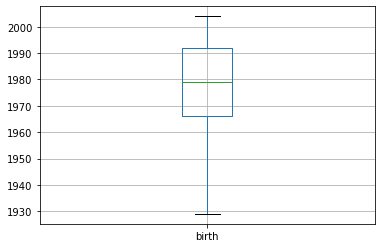

In [339]:
# Vérification visuelle de valeurs abérantes pour les années de naissances
df_client[["birth"]].boxplot()
plt.savefig("Boxplot années de naissance", dpi=300)


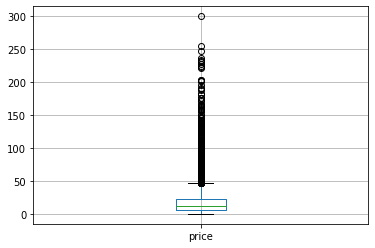

In [340]:
# Vérification visuelle de valeurs abérantes pour les prix
df_produit[["price"]].boxplot()
plt.savefig("Boxplot prix", dpi=300)


## Jonction des tables 

In [238]:
# On peut maintenant joindre nos tables produit et client sur la table vente pour augmenter les informations sur les ventes
df_vente_produit = df_vente.merge(df_produit, how="left")

In [239]:
df_vente_produit


,id_prod,date,session_id,client_id,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2.0
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1.0
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0.0
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0.0
...,...,...,...,...,...,...
336811,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,31.99,1.0
336812,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,22.99,0.0
336813,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,11.03,0.0
336814,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,50.99,2.0


In [240]:
df_all = df_vente_produit.merge(df_client, how="left")

## Gestion des valeurs NaN après jonction

In [241]:
# On vérifie sur toutes les lignes on bien étées remplies
df_nan = df_all[df_all.isna().any(axis=1)]
df_nan

,id_prod,date,session_id,client_id,price,categ,sex,birth
6231,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,NaN,NaN,m,1972
10797,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,NaN,NaN,m,1973
14045,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,NaN,NaN,f,1975
17480,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,NaN,NaN,f,1982
21071,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,NaN,NaN,m,1988
...,...,...,...,...,...,...,...,...
322523,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167,NaN,NaN,f,1979
329226,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790,NaN,NaN,f,1983
330297,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189,NaN,NaN,f,1984
335331,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595,NaN,NaN,f,1973


In [242]:
# Pour 103 lignes nous n'avons pas de valeurs price et categ
df_nan.id_prod.value_counts()


0_2245    103
Name: id_prod, dtype: int64

In [243]:
# On se rend compte que ce produit n'est pas enregistré dans la dataframe produit
df_produit.loc[df_produit["id_prod"] == "0_2245"]

,id_prod,price,categ


In [244]:
# On va remplacer les valeurs vide avec SimpleImputer, ici pour la colonne price
imputer = SimpleImputer(strategy="mean")
imputer.fit(df_all[["price"]])
df_all["price"] = imputer.transform(df_all[["price"]])
imputer.statistics_

array([17.21518851])

In [245]:
# ici pour la colonne categ
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df_all[["categ"]])
df_all["categ"] = imputer.transform(df_all[["categ"]])
imputer.statistics_

array([0.])

In [246]:
# les valeurs ont bien disparues
df_nan = df_all[df_all.isna().any(axis=1)]
df_nan


,id_prod,date,session_id,client_id,price,categ,sex,birth


## Création de nouvelles colonnes

In [247]:
# extraction de l'année, la date, les jours, le mois, l'heure à partir de la colonne date
locale.setlocale(locale.LC_ALL, "fr_FR")

df_all["day"] = pd.DatetimeIndex(df_all.date).strftime("%A")
df_all["month"] = pd.DatetimeIndex(df_all.date).strftime("%B")
df_all["hour"] = pd.DatetimeIndex(df_all.date).strftime("%H:%M")
df_all["year"] = pd.DatetimeIndex(df_all.date).strftime("%Y")
df_all["date_2"] = pd.DatetimeIndex(df_all.date).strftime("%d %m %Y")
df_all["hours"] = pd.DatetimeIndex(df_all.date).strftime("%H")
df_all["month_year"] = pd.DatetimeIndex(df_all.date).strftime("%m %Y")
df_all["month_num"] = pd.DatetimeIndex(df_all.date).strftime("%m")

In [248]:
# Changement du type de la colonne year pour pouvoir faire des opérations
df_all["year"] = pd.to_numeric(df_all["year"])
df_all

,id_prod,date,session_id,client_id,price,categ,sex,birth,day,month,hour,year,date_2,hours,month_year,month_num
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0,f,1977,samedi,avril,18:37,2021,10 04 2021,18,04 2021,04
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2.0,f,2000,jeudi,février,01:55,2022,03 02 2022,01,02 2022,02
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1.0,f,1979,jeudi,septembre,15:13,2021,23 09 2021,15,09 2021,09
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0.0,m,1963,dimanche,octobre,03:27,2021,17 10 2021,03,10 2021,10
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0.0,f,1980,samedi,juillet,20:34,2021,17 07 2021,20,07 2021,07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336811,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,31.99,1.0,m,1969,vendredi,mai,12:35,2021,28 05 2021,12,05 2021,05
336812,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,22.99,0.0,m,1991,samedi,juin,00:19,2021,19 06 2021,00,06 2021,06
336813,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,11.03,0.0,f,1968,mardi,mars,17:31,2021,16 03 2021,17,03 2021,03
336814,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,50.99,2.0,f,1994,samedi,octobre,16:50,2021,30 10 2021,16,10 2021,10


In [249]:
# Création de la colonne âge
df_all["age"] = df_all.year - df_all.birth
df_all

,id_prod,date,session_id,client_id,price,categ,sex,birth,day,month,hour,year,date_2,hours,month_year,month_num,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0,f,1977,samedi,avril,18:37,2021,10 04 2021,18,04 2021,04,44
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2.0,f,2000,jeudi,février,01:55,2022,03 02 2022,01,02 2022,02,22
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1.0,f,1979,jeudi,septembre,15:13,2021,23 09 2021,15,09 2021,09,42
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0.0,m,1963,dimanche,octobre,03:27,2021,17 10 2021,03,10 2021,10,58
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0.0,f,1980,samedi,juillet,20:34,2021,17 07 2021,20,07 2021,07,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336811,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,31.99,1.0,m,1969,vendredi,mai,12:35,2021,28 05 2021,12,05 2021,05,52
336812,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,22.99,0.0,m,1991,samedi,juin,00:19,2021,19 06 2021,00,06 2021,06,30
336813,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,11.03,0.0,f,1968,mardi,mars,17:31,2021,16 03 2021,17,03 2021,03,53
336814,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,50.99,2.0,f,1994,samedi,octobre,16:50,2021,30 10 2021,16,10 2021,10,27


# Mission n° 2 : Analyses des données 

## Indicateurs de tendances centrale (mean, median=quartilles 50%) et de dispersion (std, quartilles):

In [250]:
# pd.set_option('display.float_format', lambda x: '%.3f' % x) --> pour définir le nombre de virgule sur tout les output pandas
stats = df_all.describe().applymap("{:.1f}".format)
stats

,price,categ,birth,year,age
count,336816.0,336816.0,336816.0,336816.0,336816.0
mean,17.2,0.4,1977.8,2021.2,43.4
std,17.9,0.6,13.5,0.4,13.5
min,0.6,0.0,1929.0,2021.0,17.0
25%,8.6,0.0,1971.0,2021.0,34.0
50%,13.9,0.0,1980.0,2021.0,42.0
75%,19.0,1.0,1987.0,2021.0,51.0
max,300.0,2.0,2004.0,2022.0,93.0


## Analyse de concentration (via une courbe de Lorenz et un indice de Gini)

In [251]:
df_all


,id_prod,date,session_id,client_id,price,categ,sex,birth,day,month,hour,year,date_2,hours,month_year,month_num,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0,f,1977,samedi,avril,18:37,2021,10 04 2021,18,04 2021,04,44
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2.0,f,2000,jeudi,février,01:55,2022,03 02 2022,01,02 2022,02,22
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1.0,f,1979,jeudi,septembre,15:13,2021,23 09 2021,15,09 2021,09,42
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0.0,m,1963,dimanche,octobre,03:27,2021,17 10 2021,03,10 2021,10,58
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0.0,f,1980,samedi,juillet,20:34,2021,17 07 2021,20,07 2021,07,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336811,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,31.99,1.0,m,1969,vendredi,mai,12:35,2021,28 05 2021,12,05 2021,05,52
336812,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,22.99,0.0,m,1991,samedi,juin,00:19,2021,19 06 2021,00,06 2021,06,30
336813,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,11.03,0.0,f,1968,mardi,mars,17:31,2021,16 03 2021,17,03 2021,03,53
336814,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,50.99,2.0,f,1994,samedi,octobre,16:50,2021,30 10 2021,16,10 2021,10,27


In [252]:
def lorenz(arr):
    lorenz = np.cumsum(np.sort(arr)) / arr.sum()
    return np.append([0], lorenz)


def plot_lorenz_curve(lorenz_curve, title):
    xaxis = np.linspace(0.0, 1.0, lorenz_curve.size)
    plt.plot([0, 1], [0, 1], color="k")
    plt.plot(xaxis, lorenz_curve)
    plt.title("Courbe de lorenz : {}".format(title))
    plt.show()


def gini(arr, lorenz_curve):
    AUC = (
        lorenz_curve.sum() - lorenz_curve[-1] / 2 - lorenz_curve[0] / 2
    ) / lorenz_curve.size
    S = 0.5 - AUC
    gini = 2 * S
    return gini

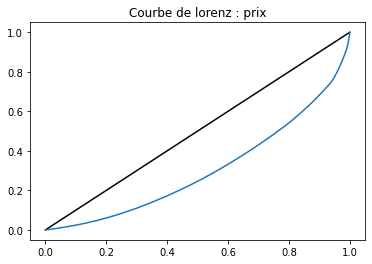

Le coeficient de gini pour la catégorie est : 0.39207298082560627


<Figure size 432x288 with 0 Axes>

In [342]:
price_arr = df_all.price
price_lorenz_curve = lorenz(price_arr)
plot_lorenz_curve(price_lorenz_curve, "prix")
print(
    "Le coeficient de gini pour la catégorie est : {}".format(
        gini(price_arr, price_lorenz_curve)
    )
)

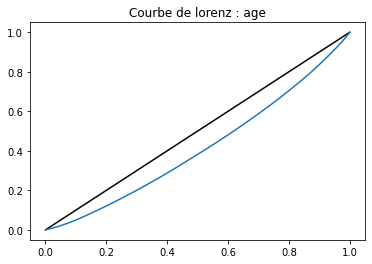

Le coeficient de gini pour l'age est : 0.17253378068206437


In [254]:
age_arr = df_all.age
age_lorenz_curve = lorenz(age_arr)
plot_lorenz_curve(age_lorenz_curve, "age")
print(
    "Le coeficient de gini pour l'age est : {}".format(gini(age_arr, age_lorenz_curve))
)

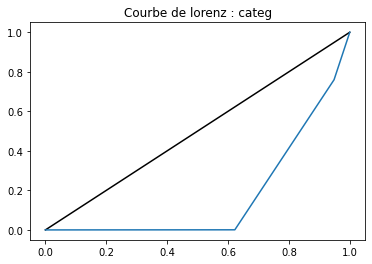

Le coeficient de gini pour la catégorie est : 0.6615699264435175


In [255]:
categ_arr = df_all.categ
categ_lorenz_curve = lorenz(categ_arr)
plot_lorenz_curve(categ_lorenz_curve, "categ")
print(
    "Le coeficient de gini pour la catégorie est : {}".format(
        gini(categ_arr, categ_lorenz_curve)
    )
)

## Représentations graphiques 

### Histogrammes

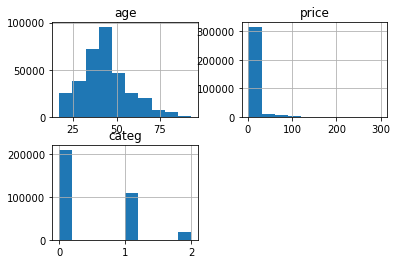

In [343]:
# Visualisation de la distribution pour l'âge, le prix et la catégorie
hist = df_all[["age", "price", "categ"]].hist()
plt.savefig("histogramme", dpi=300)


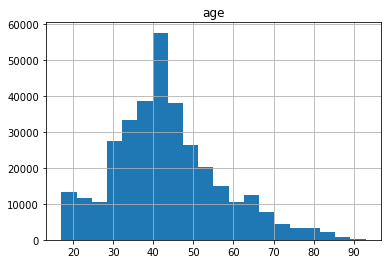

In [344]:
df_all.hist("age", bins=20)
plt.savefig("histogramme age", dpi=300)


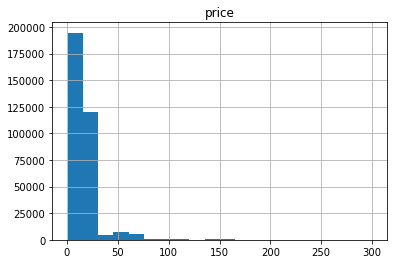

In [345]:
df_all.hist("price", bins=20)
plt.savefig("histogramme prix", dpi=300)


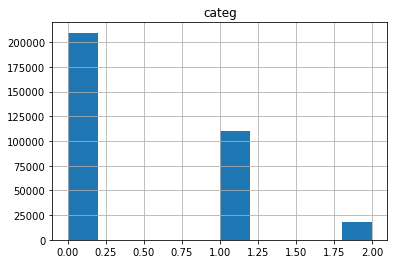

In [346]:
df_all.hist("categ")
plt.savefig("histogramme categ", dpi=300)


### Boite à moustache

<AxesSubplot:>

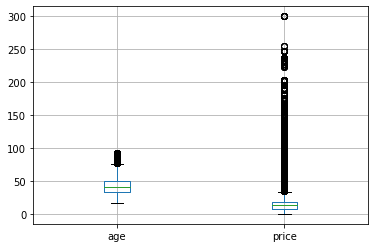

In [260]:
# df_all[['age','price', 'categ']].boxplot()
df_all.boxplot(column=["age", "price"])

### Séries temporelle

In [261]:
df_all.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 336815
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     336816 non-null  object 
 1   date        336816 non-null  object 
 2   session_id  336816 non-null  object 
 3   client_id   336816 non-null  object 
 4   price       336816 non-null  float64
 5   categ       336816 non-null  float64
 6   sex         336816 non-null  object 
 7   birth       336816 non-null  int64  
 8   day         336816 non-null  object 
 9   month       336816 non-null  object 
 10  hour        336816 non-null  object 
 11  year        336816 non-null  int64  
 12  date_2      336816 non-null  object 
 13  hours       336816 non-null  object 
 14  month_year  336816 non-null  object 
 15  month_num   336816 non-null  object 
 16  age         336816 non-null  int64  
dtypes: float64(2), int64(3), object(12)
memory usage: 46.3+ MB


In [262]:
sell_by_month = df_all.groupby("month_year").sum()
sell_by_month["date"] = sell_by_month.index
sell_by_month = sell_by_month.sort_index(ascending=False)

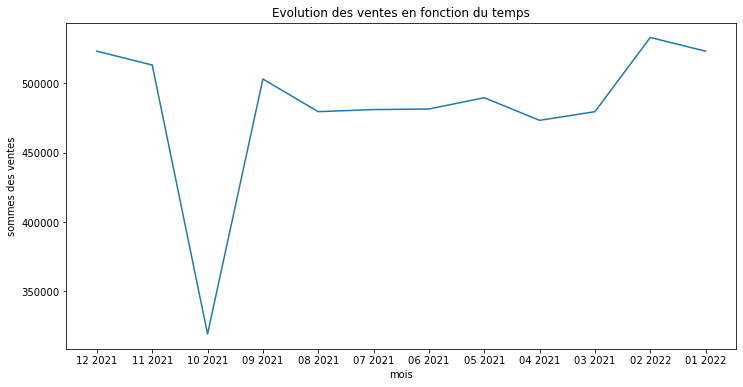

<Figure size 432x288 with 0 Axes>

In [362]:
plt.figure(figsize=(12, 6))
x = sell_by_month.date
y = sell_by_month.price
plt.plot(x, y)
plt.title("Evolution des ventes en fonction du temps")
plt.xlabel("mois")
plt.ylabel("sommes des ventes")
plt.show()

### Graphique en secteurs

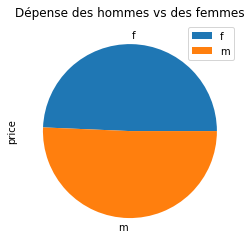

In [348]:
by_sex = df_all.groupby("sex").sum().plot(kind="pie", y="price")
plt.title("Dépense des hommes vs des femmes")
plt.savefig("Dépense des hommes vs des femmes", dpi=300)


### Diagramme en batton 

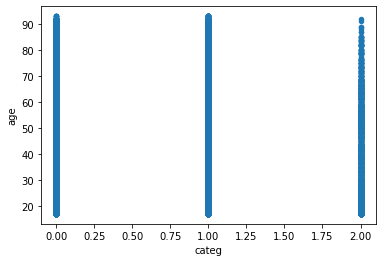

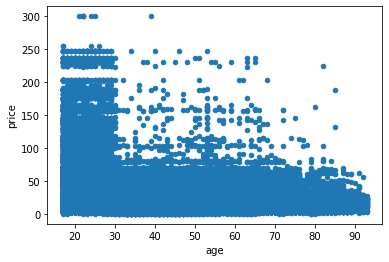

In [350]:
df_all.plot.scatter(x="categ", y="age")
plt.savefig("Diagramme categ vs age", dpi=300)
df_all.plot.scatter(y="price", x="age")
plt.savefig("Diagramme price vs age", dpi=300)


## Analyses bivariées

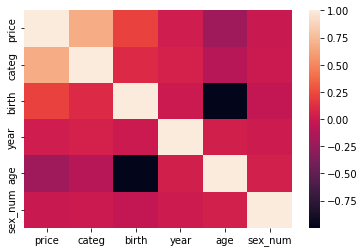

In [351]:
# heatmap des corrélations, qui permet de voir les relations entre les variables quantitatives
corr = df_all.corr()
sns.heatmap(corr)
plt.savefig("heatmap corrélation", dpi=300)


In [267]:
df_all.corr()


,price,categ,birth,year,age
price,1.000000,0.673305,0.211505,0.018517,-0.210857
categ,0.673305,1.000000,0.098602,0.054330,-0.097018
birth,0.211505,0.098602,1.000000,-0.007475,-0.999606
year,0.018517,0.054330,-0.007475,1.000000,0.035538
age,-0.210857,-0.097018,-0.999606,0.035538,1.000000


In [268]:
corr_df = corr.unstack().reset_index()
corr_df.columns = ["feature_1", "feature_2", "correlation"]
corr_df.sort_values(by="correlation", ascending=False, inplace=True)
corr_df = corr_df[corr_df["feature_1"] != corr_df["feature_2"]]
corr_df

,feature_1,feature_2,correlation
5,categ,price,0.673305
1,price,categ,0.673305
10,birth,price,0.211505
2,price,birth,0.211505
7,categ,birth,0.098602
11,birth,categ,0.098602
8,categ,year,0.054330
16,year,categ,0.054330
19,year,age,0.035538
23,age,year,0.035538


# Mission n° 3 : Corrélations

## 1. Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?

In [269]:
# Création d'une nouvelle colonne pour mettre les valeurs de la colonne sex de string en numérique :
def gender(x):
    if "m" in x:
        return 0
    elif "f" in x:
        return 1


df_all["sex_num"] = df_all["sex"].apply(gender)

In [270]:
print(
    "Le coefficent de corrélation entre la colonne sexe et categ est de {}, ce score est proche de 0, il n'y a pas de corrélation".format(
        df_all.sex_num.corr(df_all.categ)
    )
)


Le coefficent de corrélation entre la colonne sexe et categ est de -0.0007262808446083062, ce score est proche de 0, il n'y a pas de corrélation


In [271]:
# Création d'un dataframe regroupant les valeurs par categ
by_categ = df_all.groupby("categ").mean().reset_index()
by_categ

,categ,price,birth,year,age,sex_num
0,0.0,10.650057,1978.101867,2021.155869,43.054002,0.495616
1,1.0,20.480106,1974.340876,2021.209769,46.868893,0.505481
2,2.0,75.174949,1996.271821,2021.182600,24.910779,0.470602


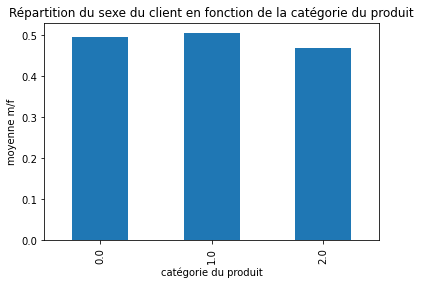

In [352]:
# Visualisation de la répartition du sexe en fonction de la categ
by_categ.plot.bar(x="categ", y="sex_num", legend=False)
plt.title("Répartition du sexe du client en fonction de la catégorie du produit")
plt.xlabel("catégorie du produit")
plt.ylabel("moyenne m/f")
plt.savefig(
    "Répartition du sexe du client en fonction de la catégorie du produit", dpi=300
)

Sur ce graphique on visualise que le sexe n'a pas beaucoup d'inpact sur la catégorie (une valeur de 0.5 correpond à une égalité entre les femmes et les homes, une valeur qui tend vers 1 correpond à une plus forte proportionalité de femmes et une valeur qui tend vers 0 correpond à une plus forte proportionalité d'homme).

## 2. Corrélations

### 2.1 Y a-t-il une corrélation entre l'âge des clients et le montant total des achats

In [278]:
# Création d'un dataframe regroupant les valeurs par clients
by_client = (
    df_all.groupby("client_id").agg({"price": sum, "age": np.mean}).reset_index()
)
by_client.rename(columns={"price": "montant_total_achats"}, inplace=True)
by_client

,client_id,montant_total_achats,age
0,c_1,300.65,66.050000
1,c_10,586.18,65.000000
2,c_100,222.87,29.000000
3,c_1000,980.02,55.250000
4,c_1001,1102.45,39.155172
...,...,...,...
8595,c_995,119.08,66.000000
8596,c_996,739.60,51.095238
8597,c_997,572.89,27.173913
8598,c_998,1527.69,20.142857


Text(0.5, 1.0, 'Dispersion du montant total des achats par client ')

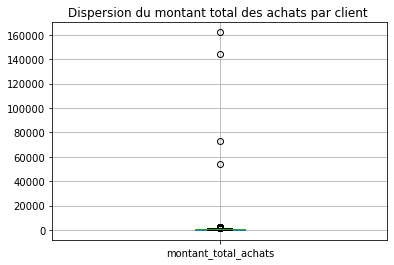

In [279]:
# Répartition du montant total des achats par client
by_client.boxplot("montant_total_achats")
plt.title("Dispersion du montant total des achats par client ")


Ici on peut voir que 4 clients sortent du lot dans leur montant total d'achat.

In [280]:
client_depensier = by_client[by_client["montant_total_achats"] > 20000].index
# Delete these row indexes from dataFrame
by_client.drop(client_depensier, inplace=True)
by_client


,client_id,montant_total_achats,age
0,c_1,300.65,66.050000
1,c_10,586.18,65.000000
2,c_100,222.87,29.000000
3,c_1000,980.02,55.250000
4,c_1001,1102.45,39.155172
...,...,...,...
8595,c_995,119.08,66.000000
8596,c_996,739.60,51.095238
8597,c_997,572.89,27.173913
8598,c_998,1527.69,20.142857


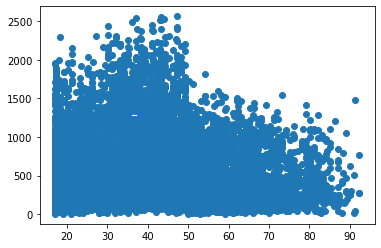

In [353]:
plt.scatter(x=by_client.age, y=by_client.montant_total_achats)
plt.savefig("montant total en fonction de l'age", dpi=300)


On peut voir que après 50 ans les clients dépensent moins.

In [282]:
print(
    "Le coefficent de corrélation entre la colonne age et montant total des achats est de {}, ce score est proche de 0, il n'y a pas forte de corrélation".format(
        by_client.age.corr(by_client.montant_total_achats)
    )
)


Le coefficent de corrélation entre la colonne age et montant total des achats est de -0.1903031649286569, ce score est proche de 0, il n'y a pas forte de corrélation


### 2.2 Y a-t-il une corrélation entre l'âge des clients et la fréquence d’achat (ie. nombre d'achats par mois par exemple)

In [338]:
by_age = df_all.groupby(["age", "month_num"]).agg({"price": "mean"}).reset_index()
by_age


,age,month_num,price
0,17,03,37.236376
1,17,04,43.179862
2,17,05,42.065232
3,17,06,39.962853
4,17,07,45.513201
...,...,...,...
907,92,10,12.385000
908,92,11,13.202500
909,92,12,16.790000
910,93,01,17.160000


### 2.3 Y a-t-il une corrélation entre l'âge des clients et La taille du panier moyen (en nombre d’articles)

<AxesSubplot:>

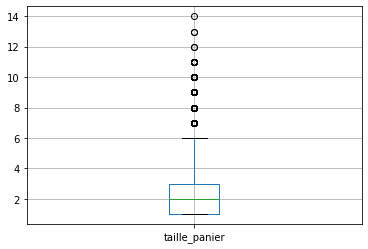

In [327]:
by_session = (
    df_all.groupby(["session_id"]).agg({"price": "count", "age": "mean"}).reset_index()
)
by_session.rename(columns={"price": "taille_panier"}, inplace=True)
by_session.boxplot("taille_panier")

In [328]:
by_session_age = (
    by_session.groupby(["age"]).agg({"taille_panier": "mean"}).reset_index()
)
by_session_age

,age,taille_panier
0,17.0,1.740675
1,18.0,1.758242
2,19.0,1.757075
3,20.0,1.728270
4,21.0,1.791032
...,...,...
75,89.0,1.552632
76,90.0,1.557377
77,91.0,1.766667
78,92.0,1.287879


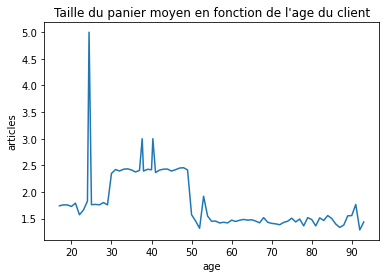

In [354]:
x = by_session_age.age
y = by_session_age.taille_panier
plt.plot(x, y)
plt.title("Taille du panier moyen en fonction de l'age du client")
plt.xlabel("age")
plt.ylabel("articles")
plt.savefig("Taille du panier moyen en fonction de l'age du client", dpi=300)


La taille moyenne du panier est plus grande avant 50 ans, avec un pic vers 25 ans.

### 2.4 Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés

In [330]:
print(
    "Le coefficent de corrélation entre la colonne age et categ est de {}, ce score est proche de 0, il n'y a pas de corrélation".format(
        df_all.age.corr(df_all.categ)
    )
)


Le coefficent de corrélation entre la colonne age et categ est de -0.09701787995585107, ce score est proche de 0, il n'y a pas de corrélation


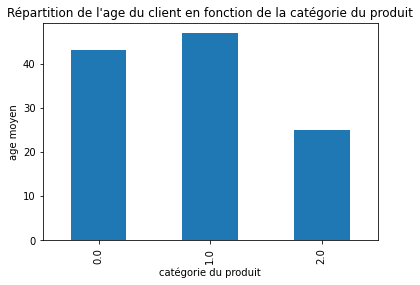

In [355]:
# Visualisation de la répartition de l'age en fonction de la categ
by_categ.plot.bar(x="categ", y="age", legend=False)
plt.title("Répartition de l'age du client en fonction de la catégorie du produit")
plt.xlabel("catégorie du produit")
plt.ylabel("age moyen")
plt.savefig(
    "Répartition de l'age du client en fonction de la catégorie du produit", dpi=300
)

In [332]:
by_cat = df_all.groupby("categ").agg({"price": "count", "age": "mean"})
by_cat

,price,age
categ,,
0.0,209529,43.054002
1.0,109735,46.868893
2.0,17552,24.910779


On a l'impression de visualiser une corrélation entre l'age et la catégorie, la moyenne d'age est plus basse pour les produit de catégorie 2, le calcul du coefficient de corrélation doit être faussé par l'inégalté de répartition entre les catégories.